# Multiclass model

## Check for acceleration

In [1]:
!nvidia-smi

Sun Jul  4 13:21:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [2]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 3.2MB/s 


In [3]:
import numpy as np
np.random.seed(2021)
import tensorflow as tf
tf.random.set_seed(2021)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import math
import random
random.seed(2021)

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras.layers as L
from keras.layers import Dense
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1.logging import INFO, set_verbosity
from tqdm import tqdm
from tensorflow.keras.regularizers import l1_l2 as L1L2
from tensorflow.keras.regularizers import l2 as L2
import efficientnet.tfkeras as efn
from IPython.display import clear_output

set_verbosity(INFO)

## Constants

In [4]:
DATA_DIR = 'data/'
os.makedirs(DATA_DIR, exist_ok=True)

CSV_FILE = os.path.join(DATA_DIR, 'nih_chest_xray_single_9c_bb_onehot.csv')
IMAGES_ARCHIVE_FILE = os.path.join(DATA_DIR, 'nih_chest_xray_single_9c_256x256.tar.gz')
IMAGES_DIR = os.path.join(DATA_DIR, 'images')

## Download the prepared dataset

In [5]:
if not os.path.exists(CSV_FILE):
    ! gdown --id 1i7oUN9QTjOavTPGgvWKq22InrTFN6mYH -O $CSV_FILE
else:
    print('CSV file ({}) already exists.'.format(CSV_FILE))

Downloading...
From: https://drive.google.com/uc?id=1i7oUN9QTjOavTPGgvWKq22InrTFN6mYH
To: /content/data/nih_chest_xray_single_9c_bb_onehot.csv
3.07MB [00:00, 97.0MB/s]


In [6]:
if not os.path.exists(IMAGES_ARCHIVE_FILE):
    ! gdown --id 1Cg7dbE1tWSBvdTfGc0G272SA_j_XocOW -O $IMAGES_ARCHIVE_FILE
else:
    print('Images archive file ({}) already exists.'.format(IMAGES_ARCHIVE_FILE))

Downloading...
From: https://drive.google.com/uc?id=1Cg7dbE1tWSBvdTfGc0G272SA_j_XocOW
To: /content/data/nih_chest_xray_single_9c_256x256.tar.gz
1.05GB [00:06, 155MB/s]


In [7]:
if not os.path.exists(IMAGES_DIR):
    ! tar -xzf $IMAGES_ARCHIVE_FILE
    print('Unpacked to {}'.format(IMAGES_DIR))
else:
    print('Images have already been unpacked ({}).'.format(IMAGES_DIR))

Unpacked to data/images


## Explore the dataset


In [8]:
df = pd.read_csv(CSV_FILE)
df

,Image Index,Finding Labels,Patient Age,Patient Gender,bb_x,bb_y,bb_w,bb_h,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,No Finding,Nodule,Pneumonia,Pneumothorax,File Path
0,00000001_000.png,Cardiomegaly,57,M,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,data/images/00000001_000.png
1,00000005_003.png,No Finding,69,F,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00000005_003.png
2,00000005_006.png,Infiltration,70,F,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,data/images/00000005_006.png
3,00000008_000.png,Cardiomegaly,68,F,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,data/images/00000008_000.png
4,00000008_002.png,Nodule,72,F,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,data/images/00000008_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36526,00030789_000.png,Infiltration,51,F,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,data/images/00030789_000.png
36527,00030798_000.png,No Finding,29,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030798_000.png
36528,00030799_000.png,No Finding,32,M,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030799_000.png
36529,00030800_000.png,No Finding,33,F,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,data/images/00030800_000.png


### Prepare Data for Training and Testing

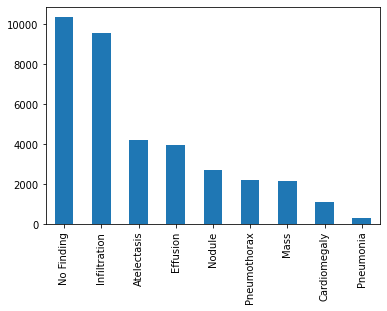

In [9]:
LABELS = list(df.columns[8:17])
df['Finding Labels'].value_counts().plot(kind='bar')

In [10]:
DISCARD = 0.7
TEST_SIZE = 0.15
VAL_SIZE = 0.15

In [11]:
if DISCARD:
    df, _ = train_test_split(
        df,
        test_size=DISCARD,
        random_state=2021,
        shuffle=True,
        stratify=df['Finding Labels']
    )

tmp_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=2021,
    shuffle=True,
    stratify=df['Finding Labels']
)

train_df, val_df = train_test_split(
    tmp_df,
    test_size=VAL_SIZE/(1.0-TEST_SIZE),
    random_state=2021,
    shuffle=True,
    stratify=tmp_df['Finding Labels']
)

In [12]:
print(len(df))
print(len(train_df))
print(len(val_df))
print(len(test_df))
print()
print(len(train_df)/len(df)*100)
print(len(val_df)/len(df)*100)
print(len(test_df)/len(df)*100)

10959
7671
1644
1644

69.99726252395291
15.001368738023544
15.001368738023544


No Finding      2176
Infiltration    2004
Atelectasis      885
Effusion         830
Nodule           568
Pneumothorax     460
Mass             450
Cardiomegaly     230
Pneumonia         68
Name: Finding Labels, dtype: int64


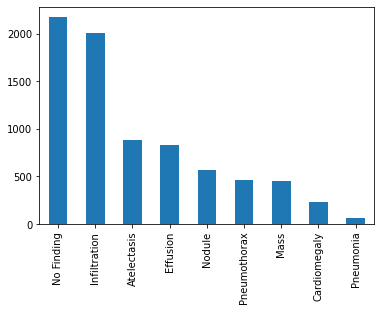

In [13]:
print(train_df['Finding Labels'].value_counts())
train_df['Finding Labels'].value_counts().plot(kind='bar')

## Create data pipeline


In [14]:
## Create data pipeline for training

def get_train_generator(df, file_path_col, labels, batch_size, image_size,
                        color_mode='grayscale'):
    image_generator = ImageDataGenerator(
        samplewise_center=True,  # Set each sample mean to 0.
        samplewise_std_normalization=True,  # Divide each input by its std
        rotation_range=5,  # Degree range for random rotations
        width_shift_range=0.1,  # fraction of total width
        height_shift_range=0.05,  # fraction of total height
        shear_range=0.1,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        zoom_range=0.15,  # Range for random zoom
        fill_mode='reflect',  # fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}
        horizontal_flip=True,  # Randomly flip inputs horizontally.
        vertical_flip=False,  # Randomly flip inputs vertically.
    )

    generator = image_generator.flow_from_dataframe(
        dataframe=df,  # Pandas dataframe containing the filepaths relative to directory (or absolute paths if directory is None)
        x_col=file_path_col,  # column in dataframe that contains the filenames
        y_col=labels,  # string or list, column/s in dataframe that has the target data.
        class_mode='raw',  # "raw": numpy array of values in y_col column(s)
        batch_size=batch_size,  # size of the batches of data
        shuffle=True,  # whether to shuffle the data (default: True)
        seed=2021,  # optional random seed for shuffling and transformations.
        target_size=image_size,  # tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized.
        color_mode=color_mode,  # one of "grayscale", "rgb", "rgba"
    )
    
    return generator

In [15]:
## Create data pipeline for testing and validation
def get_test_and_valid_generator(val_df, test_df, train_df, file_path_col, labels, batch_size, image_size, seed=2021,
                                 color_mode='grayscale'):
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        x_col=file_path_col,
        y_col=labels, 
        class_mode="raw", 
        batch_size=100,  # sample size, we will be loading only the first batch
        shuffle=True,
        seed=2021,
        target_size=image_size,
        color_mode=color_mode,
    )
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col=file_path_col,
        y_col=labels,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        target_size=image_size,
        color_mode=color_mode,
    )

    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col=file_path_col,
        y_col=labels,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        target_size=image_size,
        color_mode=color_mode,
    )
    return valid_generator, test_generator

## Training

In [16]:
EPOCHS = 30
BATCH_SIZE = 64
IMAGE_SIZE = [240, 240]  # https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
LEARNING_RATE = 1e-5

In [17]:
def create_class_weight(df, mu=0.5, use_log=True):
    total = len(df)
    class_sums = df.sum()
    if use_log:
        score = np.log(mu*total/class_sums)
    else:
        score = total/class_sums
    score[score < 1.0] = 1.0
    return score


class_weight_nolog = create_class_weight(train_df[LABELS], use_log=False)
class_weight_25 = create_class_weight(train_df[LABELS], 0.25)
class_weight_50 = create_class_weight(train_df[LABELS], 0.50)
class_weight_75 = create_class_weight(train_df[LABELS], 0.75)
class_weight_100 = create_class_weight(train_df[LABELS], 1.0)

pd.DataFrame(zip(LABELS,
                 train_df[LABELS].sum(),
                 class_weight_nolog, class_weight_25, class_weight_50, class_weight_75, class_weight_100
             ),
             columns=['Class', 'Count', 'Weight', 'Weight m=0.25', 'Weight m=0.50', 'Weight m=0.75', 'Weight m=1.0'])

,Class,Count,Weight,Weight m=0.25,Weight m=0.50,Weight m=0.75,Weight m=1.0
0,Atelectasis,885,8.667797,1.000000,1.466467,1.871933,2.159615
1,Cardiomegaly,230,33.352174,2.120829,2.813976,3.219441,3.507123
2,Effusion,830,9.242169,1.000000,1.530629,1.936094,2.223777
3,Infiltration,2004,3.827844,1.000000,1.000000,1.054620,1.342302
4,Mass,450,17.046667,1.449660,2.142808,2.548273,2.835955
5,No Finding,2176,3.525276,1.000000,1.000000,1.000000,1.259959
6,Nodule,568,13.505282,1.216786,1.909934,2.315399,2.603081
7,Pneumonia,68,112.808824,3.339400,4.032547,4.438012,4.725695
8,Pneumothorax,460,16.676087,1.427681,2.120829,2.526294,2.813976


In [18]:
class_weight = class_weight_50

In [19]:
model_transfer = tf.keras.Sequential(
    layers=[
        efn.EfficientNetB1(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False,
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation='relu', kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01)),
        L.Dropout(0.2),
        L.Dense(len(LABELS), activation='softmax'),
    ],
    name='Model_TransferLearning',
)

27164672/27164032 [==============================] - 1s 0us/step


In [20]:
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [21]:
train_generator = get_train_generator(
    df = train_df,
    file_path_col="File Path",
    labels=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    color_mode='rgb',
)

val_generator, test_generator= get_test_and_valid_generator(
    val_df=val_df,
    test_df=test_df,
    train_df=train_df,
    file_path_col="File Path",
    labels=LABELS,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    color_mode='rgb',
)

Found 7671 validated image filenames.
Found 7671 validated image filenames.
Found 1644 validated image filenames.
Found 1644 validated image filenames.


In [22]:
# Based on: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        fig = plt.figure()
        line_weight = 3
        alpha = 0.5
        ax1 = fig.add_axes([0, 0, 1, 1])
        ax2 = fig.add_axes()
        ax2 = ax1.twinx()
        lns1 = ax1.plot(self.x, self.losses, 'b-', label="loss", lw=line_weight, alpha=alpha)
        lns2 = ax1.plot(self.x, self.val_losses, 'g-', label="val_loss", lw=line_weight, alpha=alpha)
        lns3 = ax2.plot(self.x, self.accuracies, 'b--', label="accuracy", lw=line_weight, alpha=alpha)
        lns4 = ax2.plot(self.x, self.val_accuracies, 'g--', label="val_accuracy", lw=line_weight, alpha=alpha)
        lns = lns1+lns2+lns3+lns4
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc=0)
        plt.title('Epoch {}/{}'.format(self.i, EPOCHS), fontsize=20)
                
        plt.show()
        
plot_losses_cb = PlotLosses()

In [23]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=3, min_delta=0.01, verbose=1)

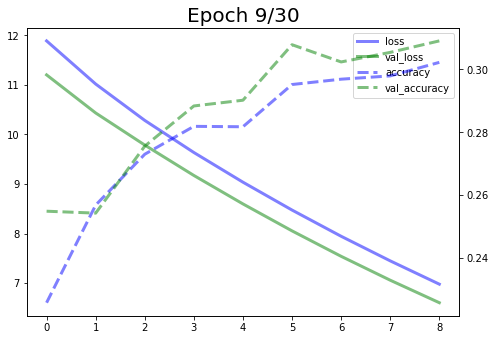

Epoch 00009: early stopping


In [24]:
history_transfer = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    class_weight={k:v for k, v in enumerate(class_weight)},
    callbacks=[
               plot_losses_cb,
               early_stop_cb,
               ]
)
